In [2]:
import pandas_datareader as web
import datetime
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math
import seaborn as sns


In [3]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 12, 31)
visa = web.DataReader('V', 'yahoo', start, end) 
visa.head()
visa.count()

High         1763
Low          1763
Open         1763
Close        1763
Volume       1763
Adj Close    1763
dtype: int64

In [4]:
#visa['Typical_Price'] = visa[['High','Low','Close']].mean(axis=1)
visa['lrets'] = (np.log(visa.Close) - np.log(visa.Close.shift(1))) * 100.
visa.head()

,High,Low,Open,Close,Volume,Adj Close,lrets
Date,,,,,,,
2014-01-02,55.507500,54.875000,55.384998,55.252499,10654000.0,52.239887,NaN
2014-01-03,55.622501,55.057499,55.437500,55.290001,7809600.0,52.275352,0.067851
2014-01-06,55.577499,54.897499,55.294998,54.957500,8577600.0,51.960972,-0.603191
2014-01-07,55.527500,55.115002,55.187500,55.377499,8178000.0,52.358078,0.761318
2014-01-08,55.750000,55.160000,55.355000,55.555000,8487200.0,52.525894,0.320018


In [5]:
visa['Stock_Price'] = (visa.Open+ visa.High + visa.Low + visa.Close)/4

In [6]:
visa= visa.round(4)
visa.tail(100)

,High,Low,Open,Close,Volume,Adj Close,lrets,Stock_Price
Date,,,,,,,,
2020-08-11,202.89,196.34,197.82,197.77,11549600.0,195.6523,0.4968,198.7050
2020-08-12,200.23,198.24,199.00,198.74,5432500.0,196.6119,0.4893,199.0525
2020-08-13,199.94,197.03,197.13,197.58,7014800.0,195.7598,-0.5854,197.9200
2020-08-14,198.07,195.77,197.01,196.64,5014400.0,194.8285,-0.4769,196.8725
2020-08-17,200.46,196.71,197.30,199.43,6256200.0,197.5927,1.4089,198.4750
...,...,...,...,...,...,...,...,...
2020-12-24,208.82,206.60,206.64,208.70,3367900.0,207.0889,1.6425,207.6900
2020-12-28,213.46,208.95,209.85,212.63,5816200.0,210.9886,1.8656,211.2225
2020-12-29,215.24,213.54,214.61,214.37,6093400.0,212.7151,0.8150,214.4400


In [7]:
visa = visa.dropna()

In [8]:
X=visa.drop(['Close'],axis=1)
y=visa['Close']
visa= visa.fillna(0)

In [9]:
X_train= X[:1410]
X_test = X[1410:]
y_train= y[:1410]
y_test=  y[1410:]

In [10]:
class RidgeRegression(object):
    def __init__(self, lmbda=0.1):
        self.lmbda = lmbda

    def fit(self, X, y):
        C = X.T.dot(X) + self.lmbda*np.eye(X.shape[1])
        self.w = np.linalg.inv(C).dot(X.T.dot(y))

    def predict(self, X):
        return X.dot(self.w)

    def get_params(self, deep=True):
        return {"lmbda": self.lmbda}

    def set_params(self, lmbda=0.1):
        self.lmbda = lmbda
        return self

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
ridge = RidgeRegression()
param_grid = [{"lmbda": 2.0**np.arange(-5, 10)}]
learner = GridSearchCV(ridge, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
learner.fit(X_train, y_train)

y_pred = learner.predict(X_test)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
ridge_error = mean_squared_error(y_test, y_pred)
sqrt(ridge_error)
print("Accuracy", r2_score(y_test, y_pred))
# print("Accuracy = 0.9435332807955", )
print("RMSE",sqrt(ridge_error))


Accuracy 0.9999999390873507
RMSE 0.0036625403169442483


In [13]:
X_test['actual']= y_test
X_test['Predicted']= y_pred

In [14]:
returns = y_pred.pct_change()
sharpe_ratio = np.sqrt(100) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.37782640793052624


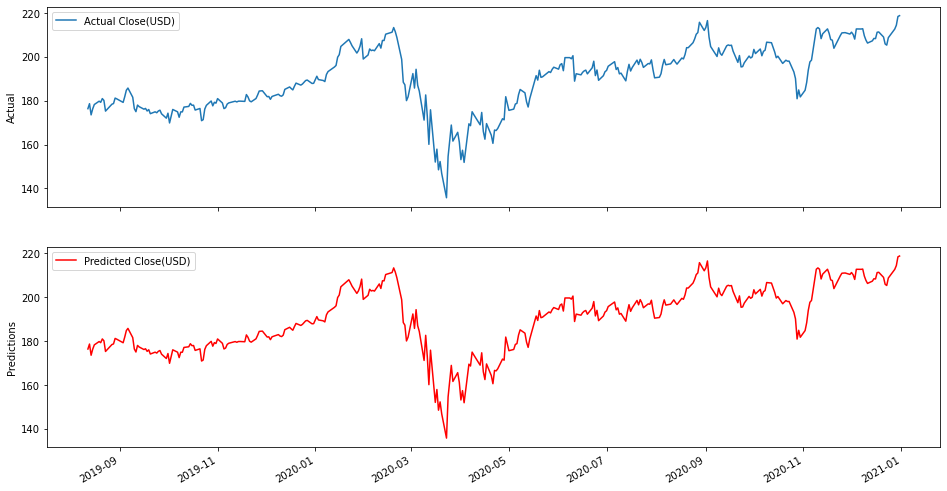

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
fig.autofmt_xdate()
ax1.plot(X_test.actual,label="Actual Close(USD)")
ax2.plot(X_test.Predicted,label="Predicted Close(USD)", color='r')
ax1.set_ylabel("Actual")
ax2.set_ylabel("Predictions")
ax1.legend(loc='best')
ax2.legend(loc='best')

In [16]:
X_test['Close']= y_test
results= X_test

###  1 Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [17]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['actual'][i])
            balance = int(amount % results['actual'][i])
            portfolio = stocks * results['actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', 
                  stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['actual'][i]
            amount = portfolio + balance
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,
                  'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,
                  'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

Stock: 176.34 Action: Buy Portfolio: 9875.04 Stocks: 56 Balance_init: 124 total($) 9999.04


Stock: 178.61 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10126.16


Stock: 173.51 Action: Buy Portfolio: 10063.58 Stocks: 58 Balance_init: 62 total($) 10125.58


Stock: 176.27 Action: Bought--Holding Portfolio: 10223.66 Stocks: 58 Balance_init: 62 total($) 10285.66


Stock: 178.23 Action: Bought--Holding Portfolio: 10337.34 Stocks: 58 Balance_init: 62 total($) 10399.34


Stock: 179.74 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10486.92


Stock: 179.24 Action: Buy Portfolio: 10395.92 Stocks: 58 Balance_init: 90 total($) 10485.92


Stock: 180.94 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10584.52


Stock: 180.09 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10584.52


Stock: 175.23 Action: Buy Portfolio: 10513.8 Stocks: 60 Balance_init: 70 total($) 10583.8


Stock: 177.59 Action: Bought--Holding Portfol

In [18]:
results= results.reset_index()

In [19]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':results.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': results.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,178.61,178.608215,2019-08-13,Buy,56,9875.04,9999.0
2,173.51,173.512797,2019-08-14,Sell,0,0.00,10126.0
3,176.27,176.270424,2019-08-15,Buy,58,10063.58,10126.0
4,178.23,178.231541,2019-08-16,Bought--Holding,58,10223.66,10286.0
5,179.74,179.739563,2019-08-19,Bought--Holding,58,10337.34,10399.0


<AxesSubplot:title={'center':'Total Amount'}>

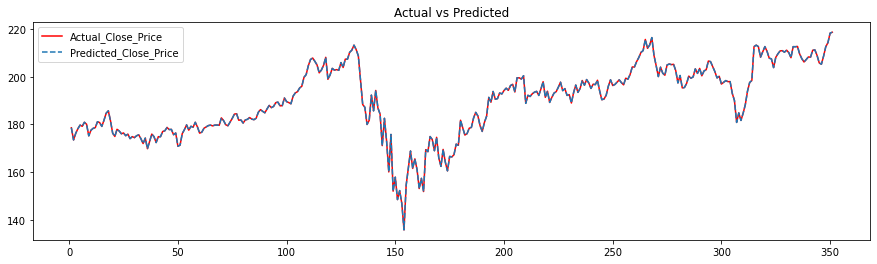

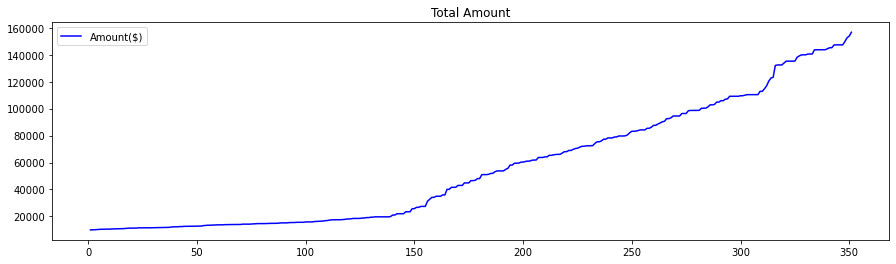

In [20]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-r','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-b'], 
                                            title = 'Total Amount')

In [21]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 156666.0 $
Profit_Percent: 1566.66 %


In [22]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()

In [23]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
Sharpe_Ratio = np.sqrt(100)*(mean_returns)/sd
Sharpe_Ratio

5.310976029535632

In [24]:
results.index= results['Date']

In [25]:
long_MA = results['actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [26]:
short_MA  = results['actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [27]:
long_std= results['actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [28]:
long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [29]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

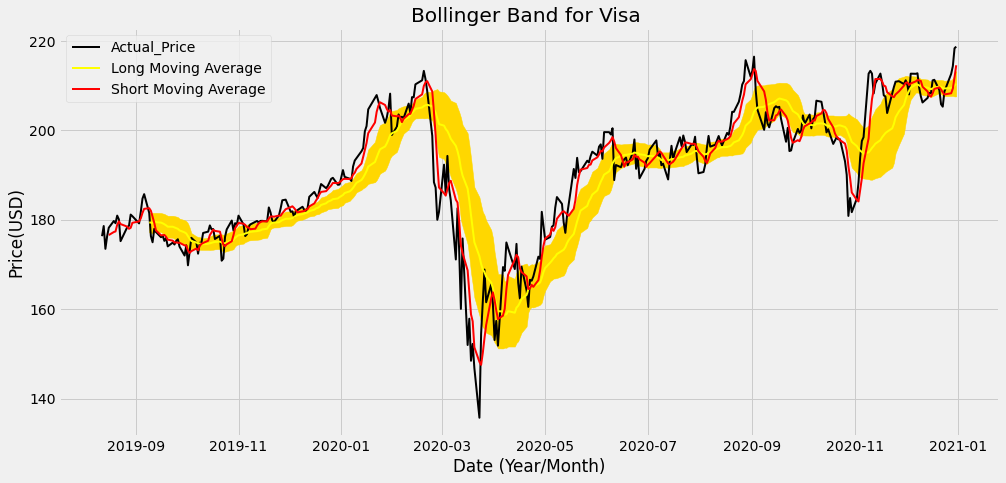

In [30]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='gold')
ax.plot(x_axis, results['actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='yellow', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='red', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for Visa ')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()